# NLP - Classic Bag of Words examples: count vectors
In this Notebook I am going to explore some classic, cheap and pretty word vectorization methods in which the word order does not matter; these, in general, are called Bag of Words (BOW). Specifically, the idea is to use word frequency vectorization and the Term frequency-Inverse term frequency (TF-IDF) matrix, which are both considered word count vectors.

In this small example I am going to try to predict the color identity of single color MTG cards using only their ruling text. 

In [411]:
import pandas as pd
import numpy as np

## Theme: Magic: The Gathering
The trading card game _Magic: The Gathering_ is, allegedly, the most computationally complex real-world game known in the literature and also Turing complete, according to https://arxiv.org/pdf/1904.09828. 

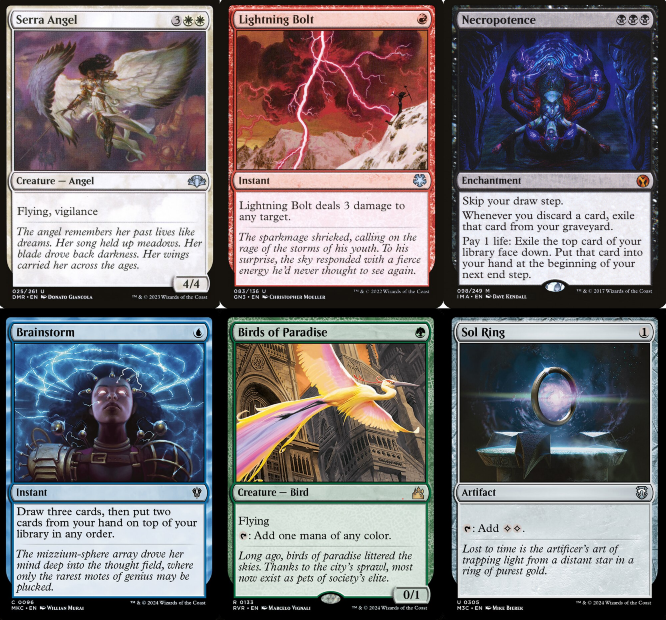

Knowing and despite that, we humans, after not long playing the game, can tell a lot things by a card description and other features: its type, subtype, color identity (mana symbols the card has); more complex things as viability in certain formats, card pairings and synergy; even we can tell how exasperating certain features are (coloquially know as "saltiness"), how fun and other emotionally driven classifications. With that we can set market prices, build decks and play tournaments.

Between those features we can find images, text, rankings, ordinal and nominal categories, numbers, etc, making it a true multimodal experience. I have always found the game a fascinating exemplification of our ability to learn and reason outside and inside the game proper. Some interactions in-game can and will get extremely convoluted, not rarely involving infinite non-deterministic loops. I have had games where I had to compute and declare an actual probability to win, unless we wanted to go throught an hours-long resolution.

With that and still knowing that the game ocurrs within a certain set of non-subjective constraints, I have long wondered: Can current artificial intelligence techniques get on par with us?

This whole repository deals with that question with an exploratory and mostly educational approach to Natural Language Processing as it is one (according to my own learning of the matter) of the most important features in a card. 

This notebook in particular deals with the color identify of a card.

## Dataset retrieval
The file cards_nlp.csv must be available in the given path. Run the MTG NLP - 0 if not present. 
Get single color (or colorless) cards, theirs names and target feature. This way, the dataset is pretty much balanced.

,name,text,colors
0,Sphinx of the Final Word,"This spell can't be countered.\nFlying, hexpro...",U
1,Goblin King,Other Goblins get +1/+1 and have mountainwalk.,R
2,Caravan Vigil,"Search your library for a basic land card, rev...",G
4,Rule of Law,Each player can't cast more than one spell eac...,W
5,Merfolk Looter,"{T}: Draw a card, then discard a card.",U
6,War Priest of Thune,"When this_card enters the battlefield, you may...",W


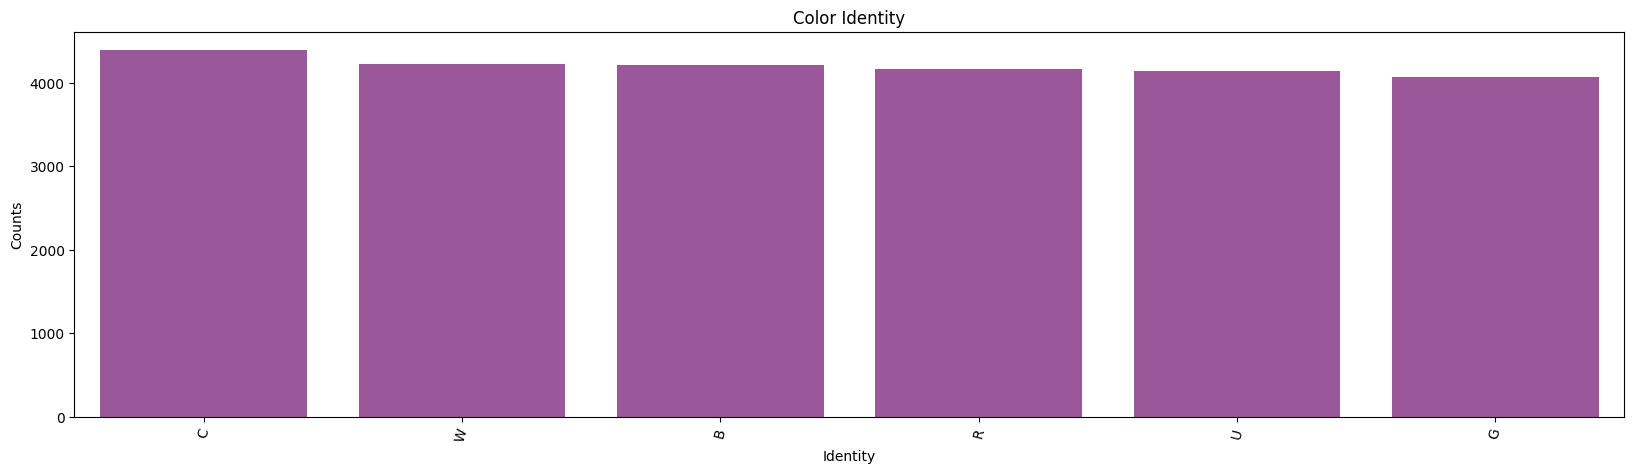

In [412]:
import matplotlib.pyplot as plt
import seaborn as sns

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if(IN_COLAB):
    import gdown
    output_file = './mtgjson_dataset/cards_nlp.csv'
    file_url = 'https://drive.google.com/file/d/1j2e1Va8Tt6bccRUdXEahsJMZD2J1o7ds/view?usp=drive_link'
    gdown.download(url = file_url, output = output_file, fuzzy=True)

data = pd.read_csv('mtgjson_dataset\cards_nlp.csv')
data = data.loc[data.colors.isin(['W','G','U','R','B','C'])]
data = data.loc[~(data.colors =='WUBRG')][['name','text','colors']]
target = 'colors'

fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(data.colors.apply(lambda x: ''.join(x)).value_counts(),color='purple',alpha=0.7,ax=ax)
for item in ax.get_xticklabels():
    item.set_rotation(75)
    item.set_fontsize(10)
ax.set_title('Color Identity')
ax.set_xlabel('Identity')
ax.set_ylabel('Counts')

data.head(6)

## Train/test split

In [413]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
target_encoder = LabelEncoder()
targets = target_encoder.fit_transform(data[target].values.ravel())
X_train, X_test, y_train, y_test =  train_test_split(data.drop(target,axis=1),
                                                     targets,
                                                     random_state=42,
                                                     train_size=0.8)

## Vectorizers
Preserving words between curly brackets (which are somewhat important keywords) and dropping english keywords. Using trigrams also proved to improve the classification (for tokens such as _enters the battlefield_)

In [414]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## Regexp pattern to detect words of at least 2 characters and also tokenize things between curls
mtg_regexp_pattern = r'\b[a-zA-Z]{2,}\b|{[^}]*}'

## Count vectorizer
cv = CountVectorizer(strip_accents = 'unicode',
                     token_pattern = mtg_regexp_pattern,
                     stop_words = 'english',
                     ngram_range=(1,3))

cv.fit(X_train.text.to_list())

## Term frequency-Inverse term frequency 
tfidf = TfidfVectorizer(strip_accents = 'unicode',
                     token_pattern = mtg_regexp_pattern,
                     stop_words = 'english',
                     ngram_range=(1,3))

tfidf.fit(X_train.text.to_list())

TfidfVectorizer(ngram_range=(1, 3), stop_words='english',
                strip_accents='unicode',
                token_pattern='\\b[a-zA-Z]{2,}\\b|{[^}]*}')

In [415]:
len(tfidf.vocabulary_)

98464

## Cosine similarity
This section explores the cosine similarity of the 5 most "similar" word vectors for any given index of the resultant sparse matrix and their targets.

In [416]:
x = tfidf.transform(X_train.text.to_list())
idx = 60

def get_most_similar(idx, sparse_x, x, top, y, encoder):
    cossim = cosine_similarity(sparse_x[idx], sparse_x)[0]
    ## Indexes, leaving out the 0 which is itself.
    most = np.argsort(cossim)[::-1][1:top]
    return x.take(most).reset_index(drop=True).join(pd.Series(encoder.inverse_transform(y).take(most),
                                                         name='target'))

get_most_similar(idx, x, X_train, 5, y_train, target_encoder)

,name,text,target
0,Mirozel,Flying\nWhen this_card becomes the target of a...,U
1,Phantasmal Bear,When this_card becomes the target of a spell o...,U
2,Skulking Fugitive,When this_card becomes the target of a spell o...,B
3,Phantom Beast,When this_card becomes the target of a spell o...,U


In [417]:
idx = 120
get_most_similar(idx, x, X_train, 5, y_train, target_encoder)

,name,text,target
0,Trailblazer's Boots,Equipped creature has nonbasic landwalk. (It c...,C
1,Skyshroud Elite,this_card gets +1/+2 as long as an opponent co...,G
2,Zodiac Horse,Islandwalk (This creature can't be blocked as ...,G
3,Segovian Leviathan,Islandwalk (This creature can't be blocked as ...,U


In [418]:
idx = 1500
get_most_similar(idx, x, X_train, 5, y_train, target_encoder)

,name,text,target
0,Rummaging Goblin,"{T}, Discard a card: Draw a card.",R
1,Manaweft Sliver,"Sliver creatures you control have ""{T}: Add on...",G
2,Battle Sliver,Sliver creatures you control get +2/+0.,R
3,Megantic Sliver,Sliver creatures you control get +3/+3.,G


In [419]:
idx = 8744
get_most_similar(idx, x, X_train, 5, y_train, target_encoder)

,name,text,target
0,Pull from the Deep,Return up to one target instant card and up to...,U
1,Shreds of Sanity,Return up to one target instant card and up to...,R
2,Relearn,Return target instant or sorcery card from you...,U
3,Call to Mind,Return target instant or sorcery card from you...,U


## Naive Bayes Classifiers - Color
Using the resultant count vector matrixes in a Multinomial and Component Naive Bayers classifier to try and predict the color identity of the input data.

### Multinomial Naive Bayes
The multinomial classifier obtains the probability $P(x_i | y)$ considering an a-priori multinomial distribution and estimating it with an smoothed version of maximum likelihood in the form
$$ \hat{P}(x_i | y) = \frac{ \sum_{x \in T} x_i + \alpha} {\sum_{i=1}^n Nyi + \alpha n}$$
where $n$ is the number of features (vocabulary in NLP case), $\sum_{x \in T} x_i$  is the number of times feature $i$ appears in a sample of class ${y}$ in the traning set ${T}$ and $\sum_{i=1}^n Nyi$ is the total count of all features of class ${y}$. $\alpha$ is a smoothing factor; when ${\alpha} = 1$ its called a Laplace smoothing and basically sets the minimum ocurrence of each term for each class at 1.

The probability of a sample being of a specific class ${y}$ is given by the naive Bayes a posteriori probability assuming each term is independant of each other. Then the inference is given by a Maximum A Posteriori (MAP) estimation in the form:

$$\hat{y} = arg \max_{{y}} P(y) \prod{_N}\hat{P}(x_i | y)$$

Where N is the total count of all features. The scikitlearn class will use the value of each feature assuming the input is a word count vector ( although tf-idf vectors are also known to work well in practice).

In [420]:
# From https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.3f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [421]:
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import accuracy_score

mnb = MultinomialNB(alpha=1)
x = cv.transform(X_train.text.to_list())
mnb.fit(X=x,y=y_train)
accuracy_score(y_test, mnb.predict(cv.transform(X_test.text.to_list())))

0.6756595913509225

In [422]:
x = tfidf.transform(X_train.text.to_list())
mnb.fit(X=x,y=y_train)
accuracy_score(y_test, mnb.predict(tfidf.transform(X_test.text.to_list())))

0.6768498313826622

### Confusion Matrix for MNB

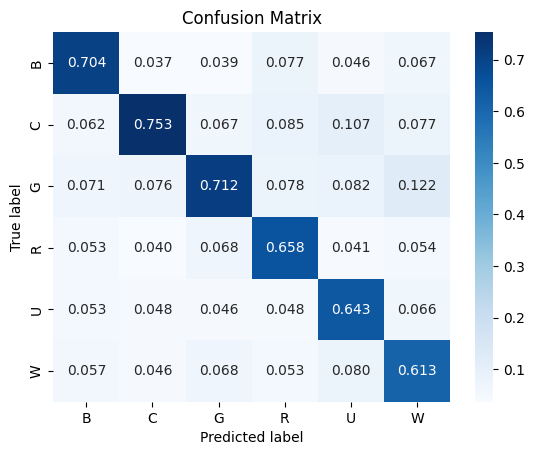

In [423]:
cf = confusion_matrix(y_true=y_test, y_pred=mnb.predict(tfidf.transform(X_test.text.to_list())), normalize='pred',labels=np.unique(y_test))
make_confusion_matrix(cf, title='Confusion Matrix',percent=False,sum_stats=False,categories=target_encoder.classes_,count=True)

### Complement Naive Bayes
Complement Naive Bayes is an adaptation of the standard multinomial naive Bayes (MNB) algorithm that is particularly suited for imbalanced data sets. Specifically, CNB uses statistics from the complement of each class to compute the model’s weights.

Reference https://people.csail.mit.edu/jrennie/papers/icml03-nb.pdf

In [424]:
cnb = ComplementNB()
x = cv.transform(X_train.text.to_list())
cnb.fit(X=x,y=y_train)
accuracy_score(y_test, cnb.predict(cv.transform(X_test.text.to_list())))

0.6806189248165047

In [425]:
x = tfidf.transform(X_train.text.to_list())
cnb.fit(X=x,y=y_train)
accuracy_score(y_test, cnb.predict(tfidf.transform(X_test.text.to_list())))

0.6810156714937512

### Most important terms or keywords
The probability $\hat{P}(x_i | y)$ encodes a sort of weight for each term according to its class. If its high, it means the terms appears more frequently in those cards, as infered by the maximum likelihood expression above. By itself, its already a good indication of the card class if a term has higher probability in a class than in the others. 

#### Color wheel
There exists a concept in _Magic_ known as _Color Wheel_ (https://magic.wizards.com/en/news/making-magic/mechanical-color-pie-2021) by which the developers loosely base the rulings, flavors and "personality" for each color. _Loosely_ is key: it is not exact. In reality, the classifers above show precicely how loose the color wheel tool is, more than how accurate the model is.

#### Most probable terms ranking by color using TF-IDF

In [426]:
sorted_vocab = {k: v for k, v in sorted(tfidf.vocabulary_.items(), key=lambda item: item[1])}
probas = pd.DataFrame(np.exp(mnb.feature_log_prob_),index=target_encoder.classes_, columns=sorted_vocab)
probas

,abandon,abandon scheme,abandon scheme set,abandoned,abandoned beginning,abandoned beginning end,abandoned creatures,abandoned creatures control,abandoned opponent,abandoned opponent cast,...,{x} {w} turn,{x} {w} {w},{x} {x},{x} {x} {1},{x} {x} {b},{x} {x} {g},{x} {x} {r},{x} {x} {t},{x} {x} {w},{x} {x} {x}
B,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,...,0.000009,0.000009,0.000011,0.000009,0.000011,0.000009,0.000009,0.000009,0.000009,0.000009
C,0.000018,0.000018,0.000010,0.000018,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,...,0.000009,0.000009,0.000020,0.000011,0.000010,0.000009,0.000009,0.000017,0.000009,0.000010
G,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,...,0.000009,0.000009,0.000011,0.000009,0.000009,0.000012,0.000009,0.000009,0.000009,0.000009
R,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,...,0.000009,0.000009,0.000017,0.000011,0.000009,0.000009,0.000016,0.000009,0.000009,0.000009
U,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,...,0.000009,0.000009,0.000010,0.000009,0.000009,0.000009,0.000009,0.000010,0.000009,0.000009
W,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,...,0.000010,0.000015,0.000011,0.000009,0.000009,0.000009,0.000009,0.000009,0.000012,0.000009


In [427]:
columns=['B','C','G','R','U','W']
pd.DataFrame([probas.transpose().B.sort_values(ascending=False).head(20).index.to_list(),
           probas.transpose().C.sort_values(ascending=False).head(20).index.to_list(),
           probas.transpose().G.sort_values(ascending=False).head(20).index.to_list(),
           probas.transpose().R.sort_values(ascending=False).head(20).index.to_list(),
           probas.transpose().U.sort_values(ascending=False).head(20).index.to_list(),
           probas.transpose().W.sort_values(ascending=False).head(20).index.to_list(),
],index=columns).transpose()

,B,C,G,R,U,W
0,creature,{t},creature,damage,flying,creature
1,life,add,{g},deals damage,card,flying
2,card,{t} add,control,deals,creature,control
3,{b},creature,card,creature,target,target
4,target,battlefield,battlefield,target,draw,turn
5,player,color,target,damage target,{u},creatures
6,graveyard,card,turn,turn,spell,battlefield
7,turn,enters battlefield,trample,deals damage target,cards,{w}
8,battlefield,enters,land,{r},draw card,end
9,target creature,{c},end,end,control,end turn


### Differences in Count Vectors and Term frequency-Inverse term frequency matrix
Observe now if I obtain the word probabilities with the help of the multinomial naive Bayes just as before but using the word count vectors. Altough the accuracy score look the same, to me (with previous game knowledge) the rankings of word probability per class using the TF-IDF matrix is more representative of the class. This speaks volumes of the TF-IDF, as the inverse document frequency smoothing filters out irrelevant terms that appears consistently in all documents, such as the word "creature". 

Naive Bayes is a very simple technique. Deep learning models will probably capture these caveats more accurately.

In [428]:
mnb = MultinomialNB(alpha=1)
x = cv.transform(X_train.text.to_list())
mnb.fit(X=x,y=y_train)
probas = pd.DataFrame(np.exp(mnb.feature_log_prob_),index=target_encoder.classes_, columns=sorted_vocab)
pd.DataFrame([probas.transpose().B.sort_values(ascending=False).head(20).index.to_list(),
           probas.transpose().C.sort_values(ascending=False).head(20).index.to_list(),
           probas.transpose().G.sort_values(ascending=False).head(20).index.to_list(),
           probas.transpose().R.sort_values(ascending=False).head(20).index.to_list(),
           probas.transpose().U.sort_values(ascending=False).head(20).index.to_list(),
           probas.transpose().W.sort_values(ascending=False).head(20).index.to_list(),
],index=columns).transpose()

,B,C,G,R,U,W
0,creature,creature,creature,creature,creature,creature
1,card,{t},control,target,card,control
2,target,card,card,damage,target,target
3,life,battlefield,target,turn,spell,turn
4,battlefield,add,battlefield,deals,control,battlefield
5,player,target,turn,deals damage,battlefield,card
6,turn,{t} add,{g},card,cast,creatures
7,{b},enters,enters,end,cards,flying
8,graveyard,enters battlefield,enters battlefield,control,turn,end
9,control,control,end,{r},{u},enters


#### Word similarity
If we transpose the idftf matrix, we can get a word-document matrix with wich we can we study the similarities between words rather than between documents as above. The first row is the word itself.

In [429]:
x_t = x.transpose()
sparse_x = x_t
top = 6

def get_similarity_words(idx,sparse_x,vocab,top):
    
    sorted_vocab = {k: v for k, v in sorted(vocab.items(), key=lambda item: item[1])}
    cossim = cosine_similarity(sparse_x[idx], sparse_x)[0]
    ## Indexes, leaving out the 0 which is itself.
    most = np.argsort(cossim)[::-1][0:top]
    return pd.DataFrame(np.array(list(sorted_vocab.keys())).take(most), columns=[list(sorted_vocab.keys())[idx]])

pd.concat([get_similarity_words(10,sparse_x,tfidf.vocabulary_,top),
           get_similarity_words(2550,sparse_x,tfidf.vocabulary_,top),
           get_similarity_words(100,sparse_x,tfidf.vocabulary_,top),
           get_similarity_words(165,sparse_x,tfidf.vocabulary_,top),
           get_similarity_words(205,sparse_x,tfidf.vocabulary_,top)
],ignore_index=True, sort=False, axis=1)       

,0,1,2,3,4
0,motion abandon scheme,target artifact activate,abilities counter target,plus abilities flying,abilities menace
1,set non ongoing,artifact activate upkeep,activated abilities permanent,abilities flying creature,abilities menace creature
2,scheme motion abandon,artifact activate,abilities counter,abilities flying,creatures creature mutates
3,non ongoing scheme,activate upkeep turn,ability permanent ability,flying creature mutates,mutates opponent discards
4,non ongoing,sacrifice creature destroy,countered way activated,mutate cost target,mutate {3} {b}
5,abandoned set non,upkeep turn,mana abilities counter,mutate cost,plus abilities menace


## Conclusions
An overall accuracy of 68% is not really that bad considering the simplicity of the model and the actual looseness of the color wheel. Plus, there over 10% samples where the text is duplicated, over all classes. A common example is just _Flying_. Its commonly associated with white, but you would be wrong 62% of times. 

Other most complex buy still classical machine learning models have been attempted without using NLP with similar results.

In [430]:
data.loc[data.text.duplicated()]['colors'].value_counts()

W    394
C    372
G    361
R    332
U    318
B    278
Name: colors, dtype: int64

In [431]:
1 - data.loc[(data.text == "Flying") & (data.colors == 'W')]['name'].count() / data.loc[data.text == 'Flying']['name'].count()

0.628099173553719